# Data Science Workshop Project

###  Dean Ayalon, Yair Hadas, Eran Horowitz 

For our project, we chose to take on the Outbrain competition presented on Kaggle. While we did not actually enter the competition, we still managed to acheive respectable results - just shy of the top 50 entries out of almost 1000 teams. In this notebook, we will show the workflow, features and models which got us there.

## Business Problem to Machine Learning Problem

Companies like Outbrain are in the business of online advertising - many high-profile websites include advertising based on Outbrain's platform, and many high-profile companies choose Outbrain as their online advertising platform. Both sides' goal is the same - to maximize the chance of the ads to be clicked. Every click means another potential customer or potential revenue for the advertiser, and it probably carries some sort of incentive for Outbrain as well.

Unlike traditional advertising platforms, advertising on the Internet can be highly personalized and tailored to each user. So the natural thing to do would be to tailor the ads to each user, in a way that would maximize the chances of an ad being clicked. But exactly how? Based on what attributes of the user and of the ad?

This is where Machine Learning comes in. Using the vast amounts of data presented by Outbrain as part of this challenge, we can build a model that would attempt to accurately predict which ad a given user will click presented a given series of ads. The info from this model could be used to design a better algorithm for choosing which ads will be presented to each user.

## A Bit More Formally

The main panel on which ads are presented to the user is called a Display. Each display has a unique id, and may consist of anywhere between 3 and 12 individual ads, each of them also having a unique id.
For each display id in the test data, we need to return an array of the ad id's, sorted in descending order of the probability they were the ones that have been clicked. The main training and test datasets only include displays in which an ad was clicked, so we know for sure one of the ads has been clicked on. 

## Introducing the Data

Outbrain provided two weeks worth of data for this challenge, for the period of 14-28.6.2016, containing information about displays, the sites they were displayed on, the ads they contained, various details about the documents these ads were linked to, the users viewing those ads, and so forth.

The full dataset for this challenge was enormous, totalling almost 100 GB when uncompressed. As we lacked the resources the handle such vast amounts of information, we chose to focus on only a small subset of the data. The full training file contains information about over 16 million different displays, we chose to sample about 3% of that amount, so the data set we worked with contained about 500,000 displays, uniformly sampled from the original data.

Some of the tables we worked with:

**clicks_train.csv** - the core table, containing display id's, the ads each display contains, and which of them was clicked.

**events.csv** - contains information about the clicks "events" - on what platform they were made (mobile,desktop or tablet), the country from which they were made, when they were made, etc.

**documents_categories.csv, documents_topic.csv, documents_entities.csv, documents_meta.csv** - tables containing various metadata details about documents, both ones which ads were displayed on, and ones which were linked to by ads.

**promoted_content.csv** - contains information about the publishers of ads and the campaigns they were part of.

The biggest table in the data was **page_views.csv**, which was essentialy the same as events.csv, but contained **all** of the page views of users tracked in those two weeks, including pages they viewed without clicking an ad. We decided to abandon this table due to the massive resources we would have needed in order to work with it.

### Importing necessary libraries and files:

In [2]:
from utils.plot_utils import *
from paths import *

#this is needed in order for the plots to be shown
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#load necessary tables:
#promoted = pd.read_csv(PROMOTED_CONTENT_YAIR)
dataset = pd.read_csv("final_main_table_4.csv")

# Data Preparation

One of the main challenges we faced was deciding how to integrate the many tables contained in the data set to one comprehensive table on which we can run our models. It took us a while to understand the connections between them, and the meanings of the various features contained in each of them. The first stage was to understand what basic features we could rely on, that is, what features don't have large proportions of null values.

# Feature Extraction

## Click Time

It's reasonable to assume that people tend to click different ads when surfing at different times of day, so we wanted to factor the time each click happened into the model.  

This required several adjustments:

1. The click timestamps provided were all UTC, so they didn't account for timezone differences between countries. At first we wanted to come up with a clever way of making this adjustment automatically for every single country in the data, but this quickly turned out to be infeasible. There are python libraries intended for this purpose, but coordinating them with our data required a lot of effort. So instead, we settled on doing it manually.

   Fortunatley for us, some countries appear in the data a lot more than others. Let's look at the ten most common:

In [10]:
#here should come the picture of the pie chart you showed me in the library. if it was made by  a code, we should insert it
#as a code. else we will upload it as a picture and explain shortly how it was done

Also, lets see how the amount of clicks distributes per hour a day:

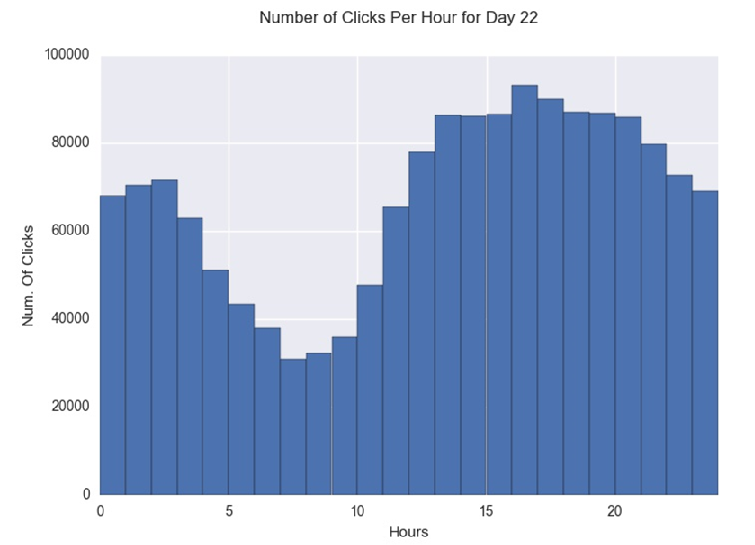

In [8]:
from IPython.display import Image
#THIS IS TEMPORARY UNTIL WE GET THE CODE THAT CREATES THE ORIGINAL HISTOGRAMS
Image("histograms/clicks_per_hour_histogram.png")

## Platforms (what was the binary that got into model?)

The data includes information about the platform from which every click was made. The possible platforms include desktop, mobile, and tablet. We expected to see a difference here as well, as each platform might be used in a different context (work vs. home for example). 

In the original dataset, this information was presented as a single digit, with possible values of 1 (desktop), 2 (mobile) and 3 (tablet). These digits are obviously numerically meaningless - desktop isn't "smaller" than mobile, and tablet isn't "bigger" than both of them. So in order to include this information in the model, we decided to create three individual binary vectors, each corresponding to one of the platforms.

We wondered if the platform might have an influance on probability of an ad to get clicked. in order to check this out we counted the amount of platforms from which clicks were made, as can be seen in the next bar chart:

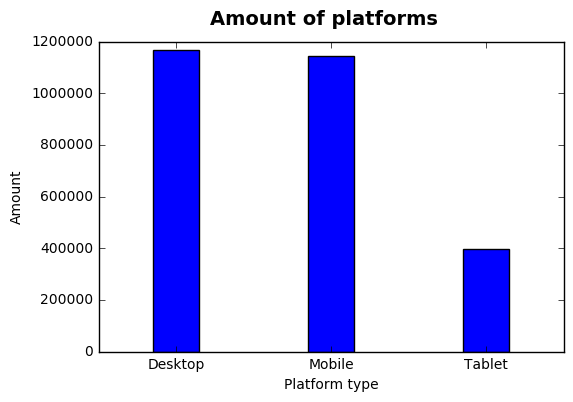

In [4]:
plot_platform_histogram(dataset)

## Weekend Clicks

We expected the clicking trends to be different over the weekends - the data includes two of them: 18-19.6 and 25-26.6.
In order to include this in the model, we created a binary vector based on the click times. This time we dind't correct for timezone, mainly because when we did the results were actually worse.

## Ads per Display

We thought the number of ads in a display might be factor affecting which ad will be clicked. 
Bigger displays might attract more attention, or repel a person from looking at them, while smaller displays might be more stealthy.

Displays of different sizes might also be located in different places on the webpage, some more likely to engage the person viewing them than others. On top of that, Outbrain's algorithms probably choose different ads for displays of different sizes, so there are probably ads which never get to be on a small display, as those are probably reserved only for ads with a high proabability of being clicked.

In the next pie chart we can see the relative part of each of the possible sizes of displays
(where size the amount of ads in it):

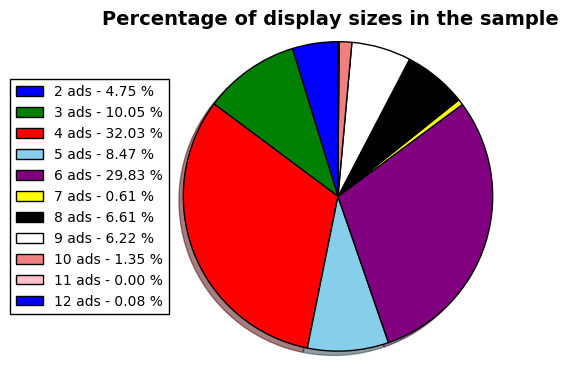

In [2]:
create_disp_number_piechart(dataset)

## Ads Per Advertiser and Ads Per Campaign

We wanted to measure the "attractiveness" of every ad - whether it's because it was published by a big-name publisher or becuase it mentions some high-profile person or company. As the topic and entity data that were provided are purely numeric, we couldn't do this directly.

Our solution was to check how many ads each advertiser published - working under the assumption that "attractive" advertisers would be big ones with a lot of money and high-profile customers, meaning they will have many more ads published than small publishers with small budgets.

We also checked for the same trend with in campaigns - trying to identift ads which are part of big campaigns.

In the following bar charts we present 50 randomly chosen advertiser and campaigns. The red bars represent the amount of ads related to each advertiser/campaign, and the blue bars - the amount of clicks it got. It can be seen that in some of the cases there is a significant gap between the amount of clicks and ads - which implies that indeed some might be more popular than the others, and therefore should be taken in account in the model.

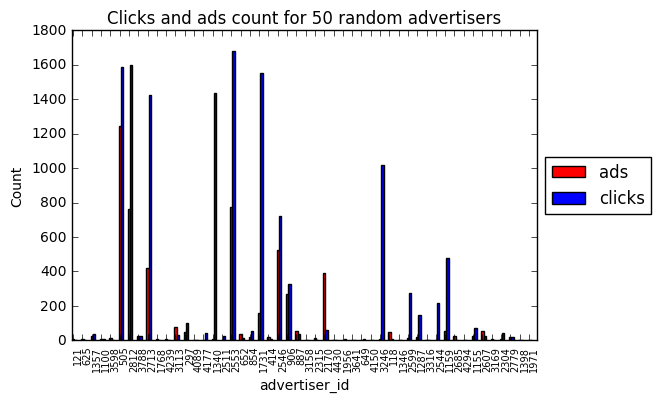

In [6]:
#here we will show the clicks per advertiser infront ads per advertiser
create_advertiser_or_campaign_pop_histogram(dataset,promoted,"advertiser_id",
                                            "Clicks and ads count for 50 random advertisers")

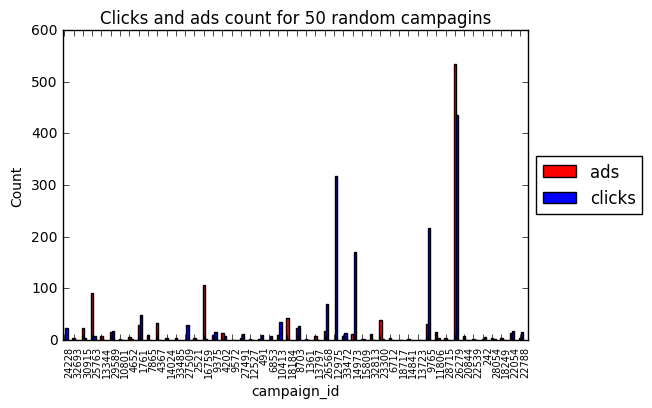

In [7]:
create_advertiser_or_campaign_pop_histogram(dataset,promoted,"campaign_id",
                                            "Clicks and ads count for 50 random campagins")

## CTR - Click Through Ratio

This turned out to be our main feature, perhaps not surprisingly. 
Our attention were first drawn to it via the article Amit sent at the beginning of the semester (https://www.csie.ntu.edu.tw/~cjlin/papers/ffm.pdf), and then again when we discovered a relatively high score of 0.63714 could be achieved based only on this metric (https://www.kaggle.com/clustifier/outbrain-click-prediction/pandas-is-cool-lb-0-63714).

In light of these discoveries, we knew it would probably be beneficial to include CTR in our model. Now we only needed to decide how to calculate it.

The naive formula for CTR is simple:
Per a given ad, divide the number of times it was clicked by the total number of appearances ("impressions") it had.
This brings up a problem - an ad which appeared once and was clicked at that time would get a CTR of 1, while an ad that appeared 100 times and was clicked 99 times would get a CTR of 0.99. The second ad got a lower rating, even though it's prbobably much more successful than the first. 

Intuitively, a CTR for an ad that appeared many times is more credible than one for an ad that didn't - it got "tested" more often, and therefore we should be able to trust the "results" more.

The soultion to this is regularization - somehow factor in the number of times an ad appeared into the calculation, so that ads that apperead more would get a "bonus" if they indeed also got a lot of clicks.

The formula used in the kernel was this:





The following histograms represent the amount of time an ad appeared and the amount of clicks it got. It can be seen beautifuly in the eye that the behavor of both histograms is very similiar, and that implies of the strong relation between those features.  

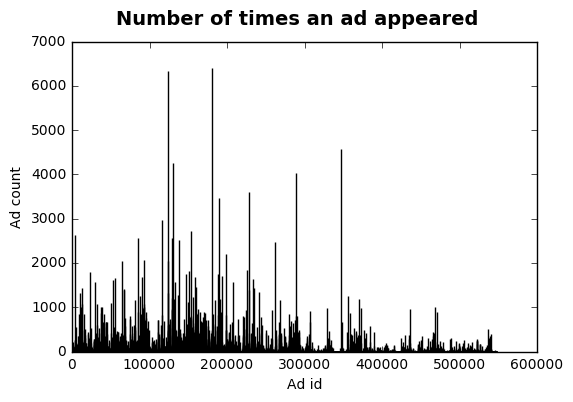

In [2]:
#adding ad appearnce histogram
create_ads_clicks_histogram(dataset,create_ad_appearance = True)

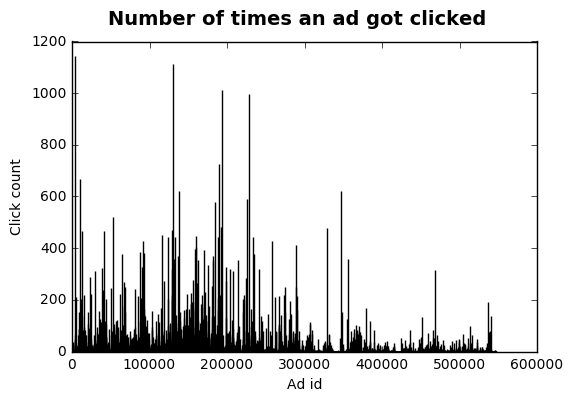

In [3]:
#adding ad clicks histogram
create_ads_clicks_histogram(dataset)

## Similarities - Do users tend to move to similiar topics?

We were wondering if users tend to click on ads that are close related to the topic of the article they just read. later we expended this thesis for enteties and categories as well.
Each topic had a confidence value between 0 to 1. 
We calculated the similiarity rate of an ad by summing the confidences multipication of the ad and every topic (or entities or categories) of a doc that this ad appeared in, if it got clicked.

We represent the results in the following bar charts. It can be seen that while the similarity feature for entities is preety rare, it is much more common for topics and categories (notice that we only picked 100 ads in categories).
We also noticed that when there is a meaningful connection between an ad and its entity, it tends to be meaningful. 

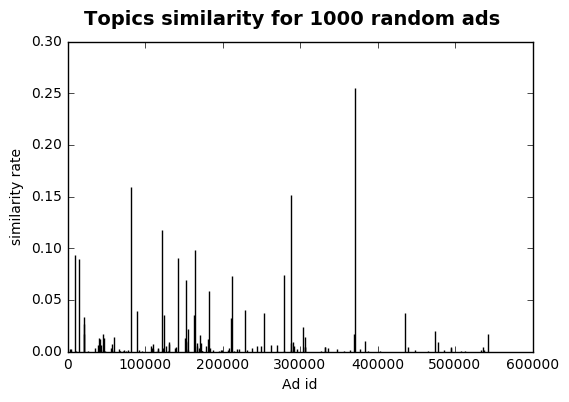

In [7]:
create_similarity_histograms(dataset,1000,"topic_sim","Topics")

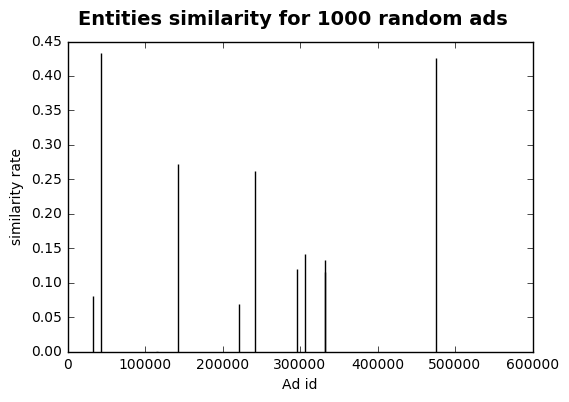

In [4]:
create_similarity_histograms(dataset,1000,"entities_sim","Entities")

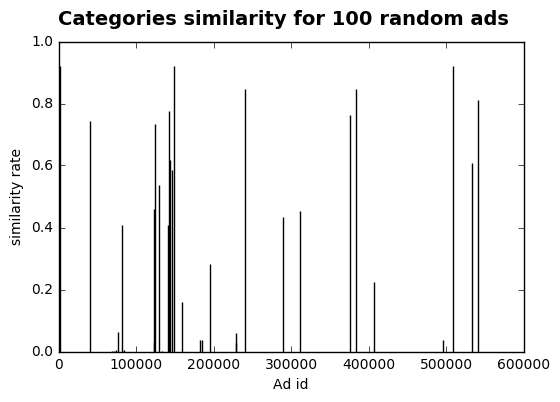

In [5]:
create_similarity_histograms(dataset,100,"categories_sim","Categories")

# Analysis - trying to predict!

## Evaluating Our Models

Models in the competition were evaluated using the MAP@12 metric, MAP standing for Mean Average Precision:

$$MAP@12 = \frac{1}{|U|} \sum_{u=1}^{|U|} \sum_{k=1}^{min(12, n)} P(k)$$

In this formulation, |U| is the number of display_id's, and P(k) is the precision at cutoff k. To try and get a better understanding of this metric, we can think of the array of ads we give in a response to a display id as a **series** of predictions, trying to predict the ad that was actually clicked. Naturally, the best case would be to make the correct prediction in the first try, but making it on the second or third attempt isn't bad either. However, making it on the last attempt isn't that satisfying. The MAP metric represents this difference.

For our data, since for every display there is only one correct answer (the ad that was actually clicked), and no display contains more than 12 ads, the formulation becomes a bit simpler:

$$MAP@12 = \frac{1}{|U|} \sum_{u=1}^{|U|} \frac{1}{r_{u}}$$

In this formulation, $r_{u}$ is the position of the correct ad in the array we return. i.e. 1 if it's first, 2 if it's second, etc. 


## Model and Parameters

After trying several other models (see documentation), it turned out the one that gave us the best results was Gradient Boosting.
We used the sklearn implementation of the Gradient Boosting Classifier. According to sklearn's documentation:

> GB builds an additive model in a forward stage-wise fashion;
...
In each stage ... regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.


As we are dealing with binary classification, only a single regression tree is built in each iteration of the algorithm. Also according to the documentation, the parameter to tune for this model is the maximum depth of the regression trees. The default value is 3 - let's use cross validation to check whether we can improve the performance by using a different value. 

In [ ]:
from gradient_boosting_analysis import *
model = perform_GBoost_analysis(perform_cv=True)
CV_Plot(model)

Turns out that for our data the best maximum depth is 4.
One of the features of the Gradient Boosting algorithm as implemented in sklearn is that it's possible to extract a "feature importances" vector. In other words - it's possible to see which features are critical to the model, and which are not. Let's look at the feature importances vector for our model:

In [2]:
#showing features importances vector, including non-important features

*#insights regarding important and unimportant features#*

To get the final evaluation score for the model, we want to use the entire dataset both as training and test, and see how the model copes with it. In other words - we want to perform Cross Validation again. The number of displays turns out to be dividable by 7, so we'll use 7-fold CV. The accuracy measures given by this method are probably he most reliable way of evaluating our model.

In [ ]:
from main_test import main_accuracy_test
main_accuracy_test()

We managed to acheive an average MAP@12 score of ****. 

For comparison, the best team in the competition got a score of 0.70145, the 50th best got a score of 0.67945, and the 100th best got a score of 0.66707.

# In conclusion

In this project we tried to give the best prediction we could for the chance of an ad in a display to get clicked.
we discovered that the strongest feature required for the predicton is the obvious one - the simple relation between the number of time an ad appeared, and the number of times it got click.
Yet the hard work, as we learned from the discussions in Kaggle.com (and also on our flesh), is to improve the accuracy even more - and to do that we were requaired to think hard on meaningful features to extract from the data, and also choose the most accurate model to predict with.
Since we got to 68.??% accuracy, we believe we have done a decent job (for comparation, this accuracy puts us in the 50 first place between 400 teams. the team who won the competition got 71.??% accuracy).

<b> probably isn't finished </b>

# What could we do to improve our results?

During the work we relised there were some things we could have done to improve and get a better results - yet we couldn't have done them because of the lake of knowledge, experiance, resources and later unfortunately time. here are some of the things we could have done better:

- <u>Using data bases:</u> unlike other projects we were required to deal with much (much) larger data, that was also orgenized in many different tables. As a result in order to extract meaningful features we had to understand the relations between the tables and to manipulate them, with an emphasis on merges. the problem was that some of the tables were so huge that the python libraries just couldn't handle them - and we got memory errors. we tried to deal with it by spliting the tables or taking only part of them, but sometimes it didn't work or it was just not right to do. those are tasks that data bases are perfect to deal with, and using one could have solve that problem, boost our efficiency and probably the results a great deal.

 
- <u>another thing:</u>

# some kind of a sum up? (optional)

-sum up description-